#Preliminaries

In [1]:
!pip3 install tensornetwork
!pip install opendatasets
!pip install tensorly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 4.7 MB/s eta 0:00:00


In [2]:
import tensornetwork as tn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorly as tl
from tensorly import unfold
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [3]:
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
mnist = fetch_openml("mnist_784")

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
mnist_dt=mnist["data"].to_numpy()
mnist_target=mnist["target"].to_numpy()

In [5]:
mnist_dt.shape

(70000, 784)

In [6]:
subset_data= mnist_dt[:1000,]
subset_targets=mnist_target[:1000,]

In [7]:
subset_data.shape

(1000, 784)

In [8]:
subset_data = subset_data.reshape(1000,28,28)
#plt.imshow(subset_data[0])

In [9]:
x_train, x_test, y_train, y_test = train_test_split( subset_data, subset_targets, test_size=0.4, random_state=42)

In [10]:
mnist_dataset_raw={"x_train":x_train,"x_test":x_test,"y_train":y_train,"y_test":y_test}

In [11]:
with open('mnist_dataset_rawinput', 'wb') as file:
    pickle.dump(mnist_dataset_raw, file)

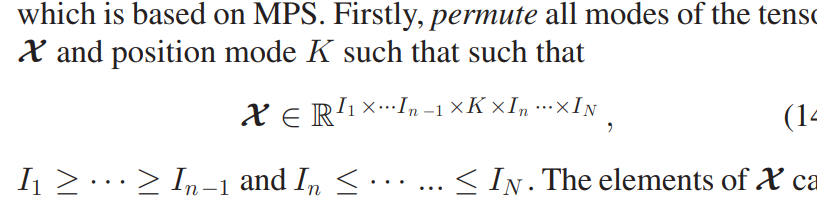

In [12]:

def prepare_dataset(dataset):
  """
  dataset is a dictionary containing x_train ,y_train, x_test, y_test where x_train,x_test
  are of shape k*I_1*I_2*....I_N where I_n is is rank, k is number of samples

  for x_train, y_train we will  permute them such that their shape becomes I_1*I_2*..*(I_n-1)*k*I_n*....I_N
  where k is number of training/testing samples and I_1>=I_2...>=(I_n-1) and  I_n<=...<=I_N

  """
  x_train, x_test, y_train, y_test=dataset.values()

  #### Permuting training data
  train_data_shape= x_train.shape
  train_data_shape=list(train_data_shape)
  k=train_data_shape[0]
  length_train_data=len(train_data_shape)

  train_data_modes=[(f"{i+1}",train_data_shape[i+1]) for i in range(length_train_data-1) ]

  sorted_shape_lst = sorted(train_data_modes, key=lambda item: item[1], reverse=True)
  midpoint = len(sorted_shape_lst) // 2

  # Divide the sorted list into two halves
  first_half = sorted_shape_lst[:midpoint]
  second_half = sorted_shape_lst[midpoint:]

  # Reverse the second half to make it non-decreasing
  second_half.reverse()

  # Concatenate the first and second halves
  sorted_shape_lst = first_half + second_half

  sorted_shape_lst.insert(midpoint,(0,k))

  permuted_shape=tuple([int(i[0]) for i in sorted_shape_lst])


  x_train=np.transpose(x_train,permuted_shape)


  #### Permuting testing data
  test_data_shape= x_test.shape

  test_data_shape=list(test_data_shape)
  l=test_data_shape[0]

  length_test_data=len(test_data_shape)

  test_data_modes=[(f"{i+1}",test_data_shape[i+1]) for i in range(length_test_data-1) ]

  sorted_shape_test_lst = sorted(test_data_modes, key=lambda item: item[1], reverse=True)
  midpoint = len(sorted_shape_test_lst) // 2

  # Divide the sorted list into two halves
  first_half_test = sorted_shape_test_lst[:midpoint]
  second_half_test = sorted_shape_test_lst[midpoint:]

  # Reverse the second half to make it non-decreasing
  second_half_test.reverse()

  # Concatenate the first and second halves
  sorted_shape_test_lst = first_half_test + second_half_test

  #permuted_test_shape_ls=[(f"{i+1}",i,first_half_test[i][1]) for i in range(len(first_half_test))]
  sorted_shape_test_lst.insert(midpoint,(0,l))

  permuted_shape_test=tuple([int(i[0]) for i in sorted_shape_test_lst])


  x_test=np.transpose(x_test,permuted_shape_test)

  #permuted_x_train_shape=[(i+1,sorted_shape_lst[1]) for i in range(len(sorted_shape_lst)) if sorted_shape_lst[0]!=0 ]

  dataset={"x_train":x_train,"x_test":x_test,"y_train":y_train,"y_test":y_test,"permuted_x_train_shape":sorted_shape_lst ,
           "permuted_x_test_shape": sorted_shape_test_lst}

  return dataset













In [13]:
max_truncation_err=0.00006  # @param {type:"number"}


In [14]:
inp_dataset= prepare_dataset(mnist_dataset_raw)

inp_x_train,inp_x_test,inp_y_train,inp_y_test,inp_x_train_shape,inp_x_test_shape=inp_dataset.values()

# Parameter


In [179]:

REDUCED_DIMENSION = 24 # @param {type:"number"}

# REDUCED_DIMENSION is number of singular values to retain

#Implementing Algorithm 1

https://arxiv.org/pdf/1609.04541

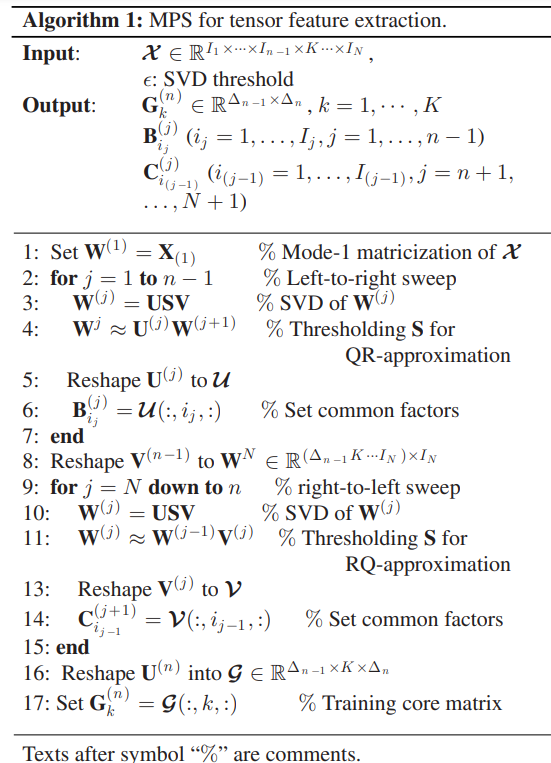

In [180]:
# @title Modelling dataset as tensor

node_x_train = tn.Node(inp_x_train)         # concrete representation of tensor from numpy array inp_x_train

W_1= tn.Node(unfold(node_x_train.tensor, 0))  # mode 1 matricization of inp_x_train  using tensorly unfold function


In [181]:
W_1.shape

(28, 16800)

In [182]:
# Calculating n, N

for i in inp_x_train_shape:
  if type(i[0])==int:
    idx_k=inp_x_train_shape.index(i)
    break

n_idx=idx_k+1

n=n_idx  # n according to algortithm when started from I_1 instead of 0 based indexing

N_idx=len(inp_x_train_shape)-1

N=N_idx



In [183]:
def svd(M):
  U, S, V = np.linalg.svd(M, full_matrices=False)
  return U, S, V

# left to right sweep

In [184]:
# @title Left to right sweep

"""### for svd I am not using tensornetwork svd because it was too complex for algorithm, I will
### use tensor data from tensornetwork node (concrete respresentation of our tensor) to do svd

for j in range(1,n):
  u,s,v= svd(W_1.tensor)"""

## To do  using above svd method figure out delta j and keep it the max_singular_value

left_common_factors_B={f"B_{i}":None for i in range(1,n)}

W_j=W_1

for j in range(1,n):

  u,s,v,t= tn.split_node_full_svd(W_j, left_edges=[W_j[0]], right_edges=[W_j[1]],max_singular_values=REDUCED_DIMENSION)   # t is truncated values

  # reshaping u for j>=2 to three order tensor to define left common factors
  if j==1:
    left_common_factors_B[f"B_{j}"]=u.tensor       # b=u when indexing b[:,i_j,:]
  else:
    u_shape=u.shape
    del_n_minus_1=u_shape[1]
    I_n_minus_1=inp_x_train_shape[j-1][1]
    del_n_minus_2=int(u_shape[0]/I_n_minus_1)

    third_order_U_shape=(del_n_minus_2,I_n_minus_1,del_n_minus_1)
    third_order_U=tn.Node(u.tensor.reshape(third_order_U_shape))


    left_common_factors_B[f"B_{j}"]=third_order_U.tensor

  #reshaping matrix v to W_j+1 for next iteration
  v_shape=v.shape
  v2w_shape=(int(v_shape[0]*inp_x_train_shape[j][1]),int(v_shape[1]/inp_x_train_shape[j][1]))

  W_j=tn.Node(v.tensor.reshape(v2w_shape))

W_N= W_j


# right to left sweep

In [185]:
# @title Right to left sweep

right_common_factors_C={f"C_{i}":None for i in range(N,n-1,-1)}

W_j=W_N

for j in range(N,n-1,-1):
  u,s,v,t= tn.split_node_full_svd(W_j, left_edges=[W_j[0]], right_edges=[W_j[1]],max_singular_values=REDUCED_DIMENSION)   # t is truncated values


  if j==N:
    right_common_factors_C[f"C_{j}"]=v.tensor       # c=v when indexing c[:,i_j,:]
  else:
    v_shape=v.shape
    del_n=v_shape[0]
    I_n=inp_x_train_shape[j][1]
    del_n_plus_1=int(v_shape[1]/I_n)

    third_order_V_shape=(del_n,I_n,del_n_plus_1)
    third_order_V=tn.Node(v.tensor.reshape(third_order_V_shape))


    right_common_factors_C[f"C_{j}"]=third_order_V.tensor


  #reshaping matrix u_j to W_j-1 for next iteration
  u_shape=u.shape
  u2w_shape=(int(u_shape[0]/inp_x_train_shape[j-1][1]),int(u_shape[1]*inp_x_train_shape[j-1][1]))

  W_j=tn.Node(u.tensor.reshape(u2w_shape))  # here W_j ===> W_N_minus_1

#W_N= W_j


# core matrix

In [186]:
# @title Core matrix G

u__n_shape= u.shape

delta_n=u__n_shape[1]
k=len(inp_x_train[0,:,0])
delta_n_minus_one=int(u__n_shape[0]/k)

G_shape=(delta_n_minus_one,k,delta_n)

G= tn.Node(u.tensor.reshape(G_shape))


In [187]:
G.shape

(24, 600, 24)

# Final dataset

In [188]:
def final_dataset(left_common_factors_B,G,right_common_factors_C):

  len_B=len(left_common_factors_B)

  prod_left_common_factors_B=np.eye(left_common_factors_B["B_1"].shape[0])

  for B in left_common_factors_B.keys():
    prod_left_common_factors_B=np.matmul(prod_left_common_factors_B,left_common_factors_B[B])

  len_C=len(right_common_factors_C)

  prod_right_common_factors_C=np.eye(right_common_factors_C[f"C_{N}"].shape[0])

  for C in right_common_factors_C:
    prod_right_common_factors_C=np.matmul(prod_right_common_factors_C,right_common_factors_C[C])



  usage_info="Data is of shape 28*K*28 where k is number of datapoints. To get a particular kth data point use B*G[:,k,:]*C where k is the permuted axis containing number of training samples. \n"


  final_dataset_artifacts={"B":prod_left_common_factors_B,"G":G,"C":prod_right_common_factors_C}

  shape_data=inp_x_train.shape
  newdata=np.zeros((shape_data))
  for k in range(shape_data[1]):
    newdata[:,k,:]= np.matmul(prod_left_common_factors_B,np.matmul(G.tensor[:,k,:],prod_right_common_factors_C))


  final_dataset={"original_data":inp_x_train,"newdata":newdata, "target":y_train,"artifacts":final_dataset_artifacts,"metrics":None,
                 "Max_truncation_error":max_truncation_err,"usage_info":usage_info}

  return final_dataset



In [189]:
final_dt=final_dataset(left_common_factors_B,G,right_common_factors_C)

In [190]:
final_dt.keys()

dict_keys(['original_data', 'newdata', 'target', 'artifacts', 'metrics', 'Max_truncation_error', 'usage_info'])

In [191]:
import pickle

with open('compressed_mnist_train_mps', 'wb') as file:
    pickle.dump(final_dt, file)

In [192]:
final_dt.keys

<function dict.keys>

In [193]:
orig_dt=final_dt["original_data"]
new_dt=final_dt["newdata"]

# summarizing results on mnist data of 600 data points

In [204]:
from scipy.stats import entropy

def variance_reduction(original_data, compressed_data):
    original_variance = np.var(original_data)
    compressed_variance = np.var(compressed_data)
    reduction = (original_variance - compressed_variance) / original_variance
    return reduction

def information_loss(original_data, compressed_data):
    mse = np.mean((original_data - compressed_data) ** 2)
    return mse

def entropy_reduction(original_data, compressed_data):
    original_entropy = entropy(np.histogram(original_data, bins='auto')[0])
    compressed_entropy = entropy(np.histogram(compressed_data, bins='auto')[0])
    reduction = (original_entropy - compressed_entropy) / original_entropy
    return reduction

# Example usage:
original_data = orig_dt[:,idx,:]
compressed_data = new_dt[:,idx,:]

variance_reduction_value = variance_reduction(original_data, compressed_data)
information_loss_value = information_loss(original_data, compressed_data)
entropy_reduction_value = entropy_reduction(original_data, compressed_data)

print("Variance Reduction:", variance_reduction_value)
print("Information Loss:", information_loss_value)
print("Entropy Reduction:", entropy_reduction_value)


Variance Reduction: 0.9999999921646248
Information Loss: 6718.505838835849
Entropy Reduction: -3.4414030063675862


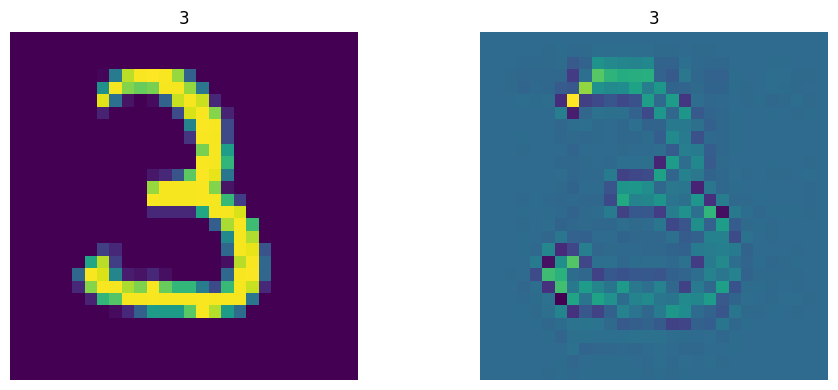

In [199]:


idx=np.random.randint(600)

img_labels = y_train[idx]
imges = [original_data[:,idx,:],compressed_data[:,idx,:]]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i, img in enumerate(imges):
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(img_labels)
    ax.axis('off')

plt.tight_layout()

plt.show()

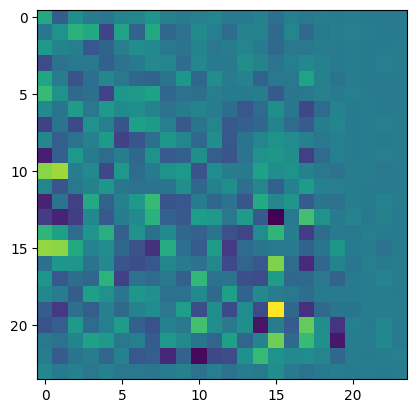

In [203]:
plt.imshow(G.tensor[:,idx,:])

In [200]:
G.shape

(24, 600, 24)